In [81]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, RandomSampler
from PIL import Image

class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.categories = []

        # Traverse the dataset folder
        self._label_to_index = {}
        self._category_to_index = {}

        for category in sorted(os.listdir(root_dir)):
            category_path = os.path.join(root_dir, category)
            if os.path.isdir(category_path):
                if category not in self._category_to_index:
                    self._category_to_index[category] = len(self._category_to_index)
                for label in sorted(os.listdir(category_path)):
                    label_path = os.path.join(category_path, label)
                    if os.path.isdir(label_path):
                        if label not in self._label_to_index:
                            self._label_to_index[label] = len(self._label_to_index)
                        for img_file in os.listdir(label_path):
                            img_path = os.path.join(label_path, img_file)
                            if img_file.endswith(('.png', '.jpg', '.jpeg')):
                                self.image_paths.append(img_path)
                                self.labels.append(self._label_to_index[label])
                                self.categories.append(self._category_to_index[category])

    @property
    def num_classes(self):
        """Returns the number of unique label classes."""
        return len(self._label_to_index)

    @property
    def num_categories(self):
        """Returns the number of unique categories."""
        return len(self._category_to_index)
    
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        category = self.categories[idx]
        return image, label

# Define the transforms you want to apply to the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a fixed size
    transforms.ToTensor(),          # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [2]:
# Example usage:
train_dir = '/home/khaled/workspace/projects/shelf-monitoring/src/data/training_set'
test_dir = '/home/khaled/workspace/projects/shelf-monitoring/src/data/test_set'
batch_size = 32
target_shape = (224, 224)

In [3]:
import os
from typing import Callable, Optional, Tuple
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import zipfile
import tempfile


class HierarchicalImageDataset(Dataset):
    def __init__(
        self,
        root: str,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        class_to_idx: Optional[dict] = None
    ):
        self.root = root
        self.transform = transform
        self.target_transform = target_transform
        
        self.temp_dir = None
        self.root_to_walk = self._prepare_root()
        
        self._classes, self.class_to_idx = self._find_classes(class_to_idx)
        self.samples = self._make_dataset()
        
    def _prepare_root(self):
        if os.path.isfile(self.root) and self.root.lower().endswith('.zip'):
            self.temp_dir = tempfile.TemporaryDirectory()
            with zipfile.ZipFile(self.root, 'r') as zip_ref:
                zip_ref.extractall(self.temp_dir.name)
            return self.temp_dir.name
        return self.root

    def _find_classes(self, class_to_idx: Optional[dict] = None) -> Tuple[list, dict]:
        if class_to_idx is not None:
            return list(class_to_idx.keys()), class_to_idx

        classes = set()
        for category in os.listdir(self.root_to_walk):
            category_path = os.path.join(self.root_to_walk, category)
            if os.path.isdir(category_path):
                for class_name in os.listdir(category_path):
                    classes.add(class_name)
        classes = sorted(list(classes))
        class_to_idx = {cls: i for i, cls in enumerate(classes)}
        return classes, class_to_idx
    
    def _make_dataset(self) -> list:
        samples = []
        for root, _, filenames in os.walk(self.root_to_walk):
            if len(filenames) > 0:
                category, class_name = os.path.split(os.path.dirname(root))
                if class_name in self.class_to_idx:
                    for img_name in filenames:
                        img_path = os.path.join(root, img_name)
                        if self._is_valid_file(img_path):
                            if self.root_to_walk != self.root:
                                relative_path = os.path.relpath(img_path, self.root_to_walk)
                                img_path = os.path.join(self.root, relative_path)
                            item = (img_path, self.class_to_idx[class_name])
                            samples.append(item)
        return samples
    
    def _is_valid_file(self, filename: str) -> bool:
        return filename.lower().endswith(('.png', '.jpg', '.jpeg'))
    
    def __len__(self) -> int:
        return len(self.samples)
    
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        path, target = self.samples[index]
        with open(path, 'rb') as f:
            img = Image.open(f).convert('RGB')
        
        if self.transform:
            img = self.transform(img)
        if self.target_transform:
            target = self.target_transform(target)
        
        return img, target
    
    @property
    def classes(self) -> list:
        return self._classes
    
    def __del__(self):
        if self.temp_dir:
            self.temp_dir.cleanup()

# Example usage:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


# Get combined class_to_idx mapping

# Create datasets with consistent class indexing
train_dataset = HierarchicalImageDataset(root=train_dir, transform=transform)
test_dataset = HierarchicalImageDataset(root=test_dir, transform=transform, class_to_idx=train_dataset.class_to_idx)

print(f"Number of classes: {len(train_dataset.classes)}")
print(f"Class to index mapping: {train_dataset.class_to_idx}")
print(f"Number of samples in training set: {len(train_dataset)}")
print(f"Number of samples in test set: {len(test_dataset)}")

# Verify consistency
print("TRAIN", list(train_dataset.class_to_idx.items())[:10])
print("TEST", list(test_dataset.class_to_idx.items())[:10])

Number of classes: 15847
Class to index mapping: {'1': 0, '10': 1, '100': 2, '1000': 3, '10000': 4, '10001': 5, '10002': 6, '10003': 7, '10004': 8, '10005': 9, '10006': 10, '10007': 11, '10008': 12, '10009': 13, '1001': 14, '10010': 15, '10011': 16, '10012': 17, '10013': 18, '10014': 19, '10015': 20, '10016': 21, '10017': 22, '10018': 23, '10019': 24, '1002': 25, '10020': 26, '10021': 27, '10022': 28, '10023': 29, '10024': 30, '10025': 31, '10026': 32, '10027': 33, '10028': 34, '10029': 35, '1003': 36, '10030': 37, '10031': 38, '10032': 39, '10033': 40, '10034': 41, '10035': 42, '10036': 43, '10037': 44, '10038': 45, '10039': 46, '1004': 47, '10040': 48, '10041': 49, '10042': 50, '10043': 51, '10044': 52, '10045': 53, '10046': 54, '10047': 55, '10048': 56, '10049': 57, '1005': 58, '10050': 59, '10051': 60, '10052': 61, '10053': 62, '10054': 63, '10055': 64, '10056': 65, '10057': 66, '10058': 67, '10059': 68, '1006': 69, '10060': 70, '10061': 71, '10062': 72, '10063': 73, '10064': 74, '

In [38]:
from torch.utils.data import DataLoader
# train_dataset = CustomImageDataset(root_dir='/home/khaled/workspace/projects/shelf-monitoring/src/data/training_set', transform=transform)

# Use RandomSampler for shuffling during training
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)

# Example: Iterate through the train loader
for images, labels in train_loader:
    print(images.shape, labels)
    break


ValueError: num_samples should be a positive integer value, but got num_samples=0

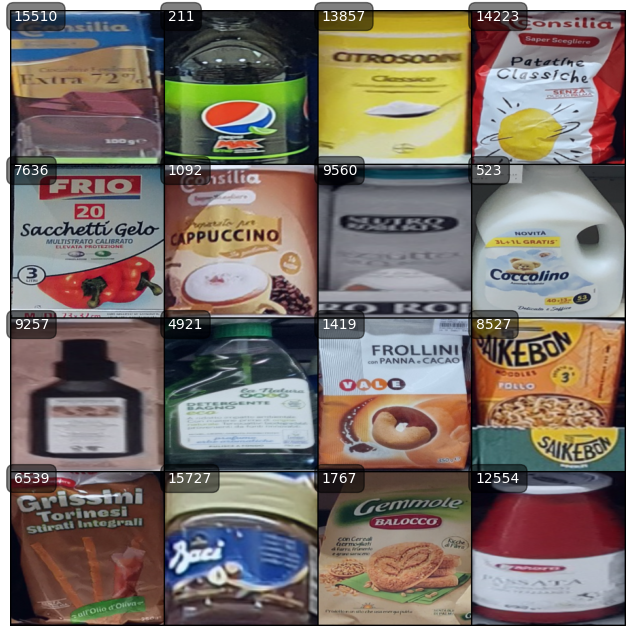

In [140]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.utils import make_grid

def plot_batch_from_dataloader(dataloader, num_cols=4):
    """
    Plots a batch of images with their corresponding labels from a DataLoader.

    Args:
        dataloader (torch.utils.data.DataLoader): DataLoader providing batches of images and labels.
        num_cols (int): Number of columns in the grid for plotting.
    """
    # Get a batch of images and labels
    images, labels = next(iter(dataloader))
    
    # Convert images to a grid and normalize
    grid = make_grid(images, nrow=num_cols, normalize=True)
    
    # Create the plot
    num_images = len(images)
    num_rows = num_images // num_cols + int(num_images % num_cols != 0)
    
    plt.figure(figsize=(num_cols * 2, num_rows * 2))
    plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
    
    # Set the labels for each image
    for i in range(num_images):
        plt.text(
            (i % num_cols) * (grid.shape[2] / num_cols) + 5,
            (i // num_cols) * (grid.shape[1] / num_rows) + 15,
            str(labels[i].item()),
            color='white',
            fontsize=10,
            bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.5')
        )
    
    plt.axis('off')
    plt.show()

# Example usage
# Assuming you have a DataLoader `dataloader`
plot_batch_from_dataloader(train_loader)


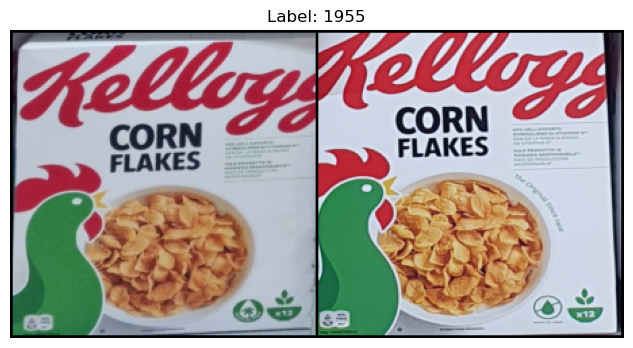

In [148]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.utils import make_grid

def visualize_two_images_with_same_label_and_category(dataloader):
    """
    Visualizes two images of the same label and their corresponding category
    after shuffling the DataLoader.

    Args:
        dataloader (torch.utils.data.DataLoader): DataLoader providing batches of images, labels, and categories.
    """
    label_to_images = {}
    label_to_category = {}

    for images, labels in dataloader:
        # Iterate over images in the batch
        for img, label in zip(images, labels):
            label = label.item()
            if label not in label_to_images:
                label_to_images[label] = []
                # label_to_category[label] = category.item()
                
            label_to_images[label].append(img)
            
            # Check if we have at least 2 images for this label
            if len(label_to_images[label]) >= 2:
                break
        # Exit if we have found at least one label with 2 images
        if len(label_to_images[label]) >= 2:
            break

    # Select a label with at least 2 images
    for label, imgs in label_to_images.items():
        if len(imgs) >= 2:
            images_to_plot = imgs[:2]  # Get the first two images with this label
            # category_to_plot = label_to_category[label]  # Get the category for this label
            break

    if len(images_to_plot) < 2:
        raise ValueError("Not enough images with the same label found.")

    # Convert images to a grid and normalize
    grid = make_grid(images_to_plot, nrow=2, normalize=True)

    # Create the plot
    plt.figure(figsize=(8, 4))
    plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
    plt.title(f"Label: {label}")
    plt.axis('off')
    plt.show()

# Example usage
# Assuming you have a DataLoader `dataloader`
visualize_two_images_with_same_label_and_category(train_loader)
